In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Fashion MNIST Dataset

In [7]:
fashion = tf.keras.datasets.fashion_mnist

(x_train, _), (_, _) = fashion.load_data()

x_train = x_train.astype("float32")/255.
x_train = tf.reshape(x_train, [60000, 28, 28, 1])

x_train.shape, x_train.dtype

(TensorShape([60000, 28, 28, 1]), tf.float32)

In [20]:
# Batching Data
train_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(100)

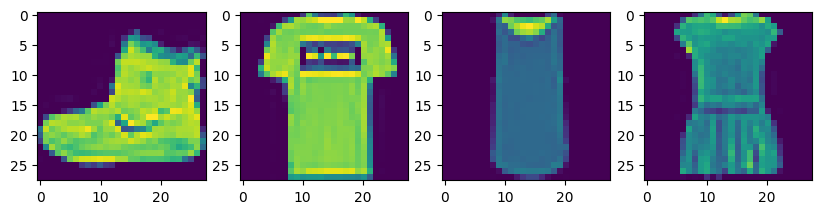

In [9]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
# Loop four times and get images 
for i in range(4): 
    # Plot the image using a specific subplot
    ax[i].imshow(np.squeeze(x_train[i]))

### Build Generator Model

In [10]:
def generator(): 
    model = tf.keras.models.Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(tf.keras.layers.Dense(7*7*128, input_dim=128))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(tf.keras.layers.Conv2D(128, 4, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(tf.keras.layers.Conv2D(128, 4, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(tf.keras.layers.Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

generator = generator()

1/1 [==============================] - 0s 59ms/step


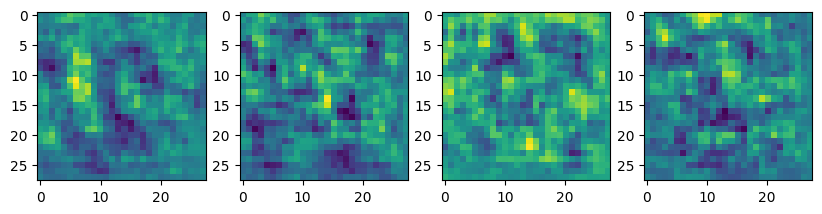

In [11]:
# Test generate image from random number
img = generator.predict(np.random.randn(4,128,1))

# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))

### Build Discriminator Model

In [12]:
def discriminator(): 
    model = tf.keras.models.Sequential()
    
    # First Conv Block
    model.add(tf.keras.layers.Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    # Second Conv Block
    model.add(tf.keras.layers.Conv2D(64, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    # Third Conv Block
    model.add(tf.keras.layers.Conv2D(128, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    # Fourth Conv Block
    model.add(tf.keras.layers.Conv2D(256, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model 

discriminator = discriminator()

### Model Training

In [13]:
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001,) 
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001) 
g_loss = tf.keras.losses.BinaryCrossentropy()
d_loss = tf.keras.losses.BinaryCrossentropy()

In [14]:
class GAN(tf.keras.models.Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for generator and discriminator
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            y_real = self.discriminator(real_images, training=True) 
            y_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([y_real, y_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(y_real), tf.ones_like(y_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(y_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(y_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [15]:
fashgan = GAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### Train Datasets

In [ ]:
# Recommended 2000 epochs
hist = fashgan.fit(train_ds, epochs=20)

In [ ]:
# Model Performance
plt.figure(figsize = (8,5), dpi = 80)
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### Generate Images

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])